In [2]:
import librosa
import matplotlib.pyplot as plt
import os
import json
import pandas as pd
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
# from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import SpectralClustering



In [36]:

def dict_morse_to_text():
    # loading dictionary with translated letters to morse code
    with open('./data/morse_code.json', "r", encoding='utf-8') as file:
        morse_code = json.load(file)
    from_morse = {}
    for key, value in morse_code.items():
        from_morse[value] = key
    # print(from_morse)
    return from_morse


#  translating sentances into morse code
def translator_from_morse(text):
    from_morse = dict_morse_to_text()
    return " ".join(["".join([from_morse.get("".join(sign.split(","))) for sign in word.split("_")]) for word in text.split(" ")])


def dict_class_to_morse(cluster_centers):
    dict = {}
    if len(cluster_centers[cluster_centers > 0]) == 1 and len(cluster_centers[cluster_centers < 0]) == 1:
        dict[0] = ','
        dict[1] = '.'
    elif len(cluster_centers[cluster_centers > 0]) == 1 and len(cluster_centers[cluster_centers < 0]) == 2:
        if (abs(cluster_centers[1]) - cluster_centers[2])**2 < (abs(cluster_centers[0]) - cluster_centers[2])**2:
        # if abs(cluster_centers[0]) > cluster_centers[cluster_centers>0][0]>abs(cluster_centers[1]):
            dict[0] = '_'
            dict[1] = ','
            dict[2] = '.'
        # elif abs(cluster_centers[0]) < cluster_centers[cluster_centers>0][0]:
        else:
            dict[0] = '_'
            dict[1] = ','
            dict[2] = '-'
    elif len(cluster_centers[cluster_centers > 0]) == 2 and len(cluster_centers[cluster_centers < 0]) == 1:
        if (abs(cluster_centers[0]) - cluster_centers[1])**2 < (abs(cluster_centers[0]) - cluster_centers[2])**2:
            dict[0] = ','
            dict[1] = '.'
            dict[2] = '-'
        elif (abs(cluster_centers[0])-cluster_centers[2])**2 < cluster_centers[cluster_centers>0][0]**2:
            dict[0] = '_'
            dict[1] = '.'
            dict[2] = '-'
        else:
            dict[0] = ' '
            dict[1] = '.'
            dict[2] = '-'
    elif len(cluster_centers[cluster_centers > 0]) == 2 and len(cluster_centers[cluster_centers < 0]) == 2:
        print(cluster_centers)
        if (abs(cluster_centers[0]) - cluster_centers[cluster_centers>0][1])**2  > cluster_centers[cluster_centers>0][0]**2 and (abs(cluster_centers[1]) - cluster_centers[cluster_centers>0][1])**2  < cluster_centers[cluster_centers>0][0]**2:
            dict[0] = ' '
            dict[1] = '_'
            dict[2] = '.'
            dict[3] = '-'
        if (abs(cluster_centers[0]) - cluster_centers[cluster_centers>0][1])**2  > cluster_centers[cluster_centers>0][0]**2 and (abs(cluster_centers[1]) - cluster_centers[cluster_centers>0][1])**2  > cluster_centers[cluster_centers>0][0]**2:
            dict[0] = ' '
            dict[1] = ','
            dict[2] = '.'
            dict[3] = '-'
        else:
            print("opcja 2")
            dict[0] = '_'
            dict[1] = ','
            dict[2] = '.'
            dict[3] = '-'

    elif len(cluster_centers) == 5:
        dict[0] = ' '
        dict[1] = '_'
        dict[2] = ','
        dict[3] = '.'
        dict[4] = '-'
    return dict


def sound_translator(path):
    samples, sampling_rate = librosa.load(path, sr=10000, mono=True, offset=0.0
                        , duration=None)
    max_abs_scaler = preprocessing.MaxAbsScaler()
    new_samples = max_abs_scaler.fit_transform(np.array(samples).reshape(1,-1).T)
    # new_samples = ((pd.Series(samples) - min(samples)) * (1 - (-1))) / (max(samples) - min(samples)) + (-1)
    threshold =np.mean(list(map(lambda i: abs(i), new_samples)))
    bin_samples = [1 if abs(new_val)>threshold else 0 for new_val in new_samples]
    bin_samples = bin_samples[bin_samples.index(1):max([i for i ,e in enumerate(bin_samples) if e == 1])+1]
    bin_samples = bin_samples[bin_samples.index(1):max([i for i ,e in enumerate(bin_samples) if e == 1])+1]
    border = 100
    new_bin_samples =  [1 for i in range(border)] + \
    [(1 if (bin_samples[i] ==1 or (np.sum(bin_samples[i-border:i]) > 0 and np.sum(bin_samples[i:i+border]) > 0)) else 0) \
     for i in list(range(border, len(bin_samples)-border))] + \
          [1 for i in range(border)]
    
    new_list = []
    k = 0
    for i in range(len(new_bin_samples)-1):
        if new_bin_samples[i] != new_bin_samples[i+1]:
            if new_bin_samples[i] == 1:
                new_list.append(i-k+1)
            else:
                new_list.append(-(i+1-k))
            k = i 
    new_list.append(len(new_bin_samples)-k)
    # new_list = [i for i in new_list if abs(i)>max(new_list)/10]
    new_list = [i for i in new_list if abs(i)>100]
    scaler = StandardScaler()
    scaled = scaler.fit_transform(np.array([i for i in new_list]).reshape(1,-1).T)
    silhouette_coefficients = []
    for k in range(2, 6):
        if(len(scaled)>k):
            clustering = SpectralClustering(n_clusters=k).fit(scaled)
            score = silhouette_score(scaled, clustering.labels_)
            silhouette_coefficients.append(score)

    n_clust = silhouette_coefficients.index(max(silhouette_coefficients))+2
    clustering = SpectralClustering(n_clusters=n_clust)
    clustering.fit(scaled)
    
    df = pd.DataFrame(columns = ['length', 'class'])
    df['length'] = new_list
    df['class'] = clustering.labels_

    cB0 =df['class']
    ord_idx=np.argsort(df.groupby(['class']).mean()['length'])
    cntrs = np.zeros_like(cB0)-1
    for i in np.arange(n_clust):
        cntrs[cB0==ord_idx[i]]=i

    df = pd.DataFrame(columns = ['length', 'class'])
    df['length'] = new_list
    df['class'] = cntrs
    dict = dict_class_to_morse(np.array([np.sort(df.groupby(['class']).mean()['length'])]).T)
    # print(df['class'])
    # print("".join([dict.get(i) for i in df['class']]))
    # try:
    return translator_from_morse("".join([dict.get(i) for i in df['class']])) 
    # except:
    #     return "Cant translate sound"

In [3]:
# !pip3 install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.2/156.2 kB 752.1 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 1.4 MB/s eta 0:00:0000:0100:010m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.4/243.4 kB 3.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 3.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.2/66.2 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 3.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.1/103.1 kB 2.6 MB/s eta 0:00:00


In [3]:
# loading dictionaru with translated letters to morse code
with open('data/morse_code.json', "r", encoding='utf-8') as file:
    morse_code = json.load(file)

In [4]:
from_morse = {}
for key, value in morse_code.items():
    from_morse[value] = key

In [8]:
# #  translating sentances into morse code
# def translator_from_text(text):
#     return " ".join("_".join([",".join([i for i in morse_code.get(i)]) for i in word]) for word in text.upper().split(" "))

In [23]:
#  translating sentances into morse code
def translator_from_morse(text):
    return " ".join(["".join([from_morse.get("".join(sign.split(","))) for sign in word.split("_")]) for word in text.split(" ")])

In [309]:
# # loading dictionaru with translated letters to morse code
# with open('./../../data/labels/labels_test.json', "r", encoding='utf-8') as file:
#     labels = json.load(file)

In [592]:
existing_file_path ="./../../data/audio/morse_text_audio_files_train/steel/12_steel.wav"#"./../../data/audio/morse_text_audio_files_test/guitar1/136_guitar1.wav"
samples, sampling_rate = librosa.load(existing_file_path)#, sr=5500, mono=True, offset=0.0
                        # , duration=None)

In [1]:
existing_file_path = "/Users/zuzannaglinka/taros-deep-learning/data/audio/unused/morse_text_audio_files/drums_2/0_drums_2.wav"#"./../../data/audio/morse_text_audio_files_test/guitar1/136_guitar1.wav"
samples, sampling_rate = librosa.load(existing_file_path, sr = 10000)#, sr=5500, mono=True, offset=0.0
                        # , duration=None)

NameError: name 'librosa' is not defined

In [14]:
def dict_class_to_morse(cluster_centers):
    dict = {}
    if len(cluster_centers[cluster_centers > 0]) == 1 and len(cluster_centers[cluster_centers < 0]) == 1:
        dict[0] = ','
        dict[1] = '.'
    elif len(cluster_centers[cluster_centers > 0]) == 1 and len(cluster_centers[cluster_centers < 0]) == 2:
        if (abs(cluster_centers[1]) - cluster_centers[2])**2 < (abs(cluster_centers[0]) - cluster_centers[2])**2:
        # if abs(cluster_centers[0]) > cluster_centers[cluster_centers>0][0]>abs(cluster_centers[1]):
            dict[0] = '_'
            dict[1] = ','
            dict[2] = '.'
        # elif abs(cluster_centers[0]) < cluster_centers[cluster_centers>0][0]:
        else:
            dict[0] = '_'
            dict[1] = ','
            dict[2] = '-'
    elif len(cluster_centers[cluster_centers > 0]) == 2 and len(cluster_centers[cluster_centers < 0]) == 1:
        if (abs(cluster_centers[0]) - cluster_centers[1])**2 < (abs(cluster_centers[0]) - cluster_centers[2])**2:
            dict[0] = ','
            dict[1] = '.'
            dict[2] = '-'
        elif (abs(cluster_centers[0])-cluster_centers[2])**2 < cluster_centers[cluster_centers>0][0]**2:
            dict[0] = '_'
            dict[1] = '.'
            dict[2] = '-'
        else:
            dict[0] = ' '
            dict[1] = '.'
            dict[2] = '-'
    elif len(cluster_centers[cluster_centers > 0]) == 2 and len(cluster_centers[cluster_centers < 0]) == 2:
        print(cluster_centers)
        if (abs(cluster_centers[0]) - cluster_centers[cluster_centers>0][1])**2  > cluster_centers[cluster_centers>0][0]**2 and (abs(cluster_centers[1]) - cluster_centers[cluster_centers>0][1])**2  < cluster_centers[cluster_centers>0][0]**2:
            dict[0] = ' '
            dict[1] = '_'
            dict[2] = '.'
            dict[3] = '-'
        if (abs(cluster_centers[0]) - cluster_centers[cluster_centers>0][1])**2  > cluster_centers[cluster_centers>0][0]**2 and (abs(cluster_centers[1]) - cluster_centers[cluster_centers>0][1])**2  > cluster_centers[cluster_centers>0][0]**2:
            dict[0] = ' '
            dict[1] = ','
            dict[2] = '.'
            dict[3] = '-'
        else:
            print("opcja 2")
            dict[0] = '_'
            dict[1] = ','
            dict[2] = '.'
            dict[3] = '-'

    elif len(cluster_centers) == 5:
        dict[0] = ' '
        dict[1] = '_'
        dict[2] = ','
        dict[3] = '.'
        dict[4] = '-'
    return dict



In [15]:

def sound_translator(path):
    samples, sampling_rate = librosa.load(path, sr=10000, mono=True, offset=0.0
                        , duration=None)
    plt.plot(samples)
    max_abs_scaler = preprocessing.MaxAbsScaler()
    new_samples = max_abs_scaler.fit_transform(np.array(samples).reshape(1,-1).T)
    # new_samples = ((pd.Series(samples) - min(samples)) * (1 - (-1))) / (max(samples) - min(samples)) + (-1)
    threshold =np.mean(list(map(lambda i: abs(i), new_samples)))
    bin_samples = [1 if abs(new_val)>threshold else 0 for new_val in new_samples]
    bin_samples = bin_samples[bin_samples.index(1):max([i for i ,e in enumerate(bin_samples) if e == 1])+1]
    bin_samples = bin_samples[bin_samples.index(1):max([i for i ,e in enumerate(bin_samples) if e == 1])+1]
    border = 100
    new_bin_samples =  [1 for i in range(border)] + \
    [(1 if (bin_samples[i] ==1 or (np.sum(bin_samples[i-border:i]) > 0 and np.sum(bin_samples[i:i+border]) > 0)) else 0) \
     for i in list(range(border, len(bin_samples)-border))] + \
          [1 for i in range(border)]
    
    new_list = []
    k = 0
    for i in range(len(new_bin_samples)-1):
        if new_bin_samples[i] != new_bin_samples[i+1]:
            if new_bin_samples[i] == 1:
                new_list.append(i-k+1)
            else:
                new_list.append(-(i+1-k))
            k = i 
    new_list.append(len(new_bin_samples)-k)
    # new_list = [i for i in new_list if abs(i)>max(new_list)/10]
    new_list = [i for i in new_list if abs(i)>100]
    scaler = StandardScaler()
    scaled = scaler.fit_transform(np.array([i for i in new_list]).reshape(1,-1).T)
    silhouette_coefficients = []
    for k in range(2, 6):
        if(len(scaled)>k):
            clustering = SpectralClustering(n_clusters=k).fit(scaled)
            score = silhouette_score(scaled, clustering.labels_)
            silhouette_coefficients.append(score)

    n_clust = silhouette_coefficients.index(max(silhouette_coefficients))+2
    clustering = SpectralClustering(n_clusters=n_clust)
    clustering.fit(scaled)
    
    df = pd.DataFrame(columns = ['length', 'class'])
    df['length'] = new_list
    df['class'] = clustering.labels_

    cB0 =df['class']
    ord_idx=np.argsort(df.groupby(['class']).mean()['length'])
    cntrs = np.zeros_like(cB0)-1
    for i in np.arange(n_clust):
        cntrs[cB0==ord_idx[i]]=i

    df = pd.DataFrame(columns = ['length', 'class'])
    df['length'] = new_list
    df['class'] = cntrs
    dict = dict_class_to_morse(np.array([np.sort(df.groupby(['class']).mean()['length'])]).T)
    # print(df['class'])
    # print("".join([dict.get(i) for i in df['class']]))
    try:
        return translator_from_morse("".join([dict.get(i) for i in df['class']])) 
    except:
        return "Cant translate sound"

In [1]:
import MorseCodeTranslator

In [16]:
sound_translator("/Users/zuzannaglinka/Library/Developer/CoreSimulator/Devices/5B03F63E-5182-47D3-BA2A-584FA601AAEF/data/Containers/Data/Application/01F8859C-9797-4759-A474-059656BBA2EE/Documents/recordings/recording-1702411880908.wav")

/var/folders/dc/tm97_rl10kj62c4gsppshgm80000gn/T/ipykernel_41004/220266040.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  samples, sampling_rate = librosa.load(path, sr=10000, mono=True, offset=0.0
/opt/homebrew/lib/python3.11/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


FileNotFoundError: [Errno 2] No such file or directory: '/Users/zuzannaglinka/Library/Developer/CoreSimulator/Devices/5B03F63E-5182-47D3-BA2A-584FA601AAEF/data/Containers/Data/Application/01F8859C-9797-4759-A474-059656BBA2EE/Documents/recordings/recording-1702411880908.wav'

In [37]:
sound_translator("/Users/zuzannaglinka/Downloads/koza_jest_fajna.wav")

'Cant translate sound'

In [38]:
sound_translator("/Users/zuzannaglinka/taros-deep-learning/data/audio/morse_text_audio_files_train/bell/3_bell.wav")

'Cant translate sound'

In [19]:
sound_translator("/Users/zuzannaglinka/Library/Developer/CoreSimulator/Devices/5B03F63E-5182-47D3-BA2A-584FA601AAEF/data/Containers/Data/Application/924BD88F-4366-47D6-B0D0-BE0C6D0285DF/Documents/recordings/SOS.wav")

/var/folders/dc/tm97_rl10kj62c4gsppshgm80000gn/T/ipykernel_41004/220266040.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  samples, sampling_rate = librosa.load(path, sr=10000, mono=True, offset=0.0
/opt/homebrew/lib/python3.11/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


FileNotFoundError: [Errno 2] No such file or directory: '/Users/zuzannaglinka/Library/Developer/CoreSimulator/Devices/5B03F63E-5182-47D3-BA2A-584FA601AAEF/data/Containers/Data/Application/924BD88F-4366-47D6-B0D0-BE0C6D0285DF/Documents/recordings/SOS.wav'

In [16]:
sound_translator("./../../data/audio/morse_text_audio_files_val/beep/12_beep.wav")


/var/folders/dc/tm97_rl10kj62c4gsppshgm80000gn/T/ipykernel_6904/1646572595.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  samples, sampling_rate = librosa.load(path, sr=5500, mono=True, offset=0.0


FileNotFoundError: [Errno 2] No such file or directory: './../../data/audio/morse_text_audio_files_val/beep/12_beep.wav'

In [39]:
for char in "Ala ma kota":
    print(char)

A
l
a
 
m
a
 
k
o
t
a


In [40]:
def dict_morse_to_text():
    with open('./data/morse_code.json', "r", encoding='utf-8') as file:
        morse_code = json.load(file)
    from_morse = {}
    for key, value in morse_code.items():
        from_morse[key] = value
    return from_morse
def text_to_morse(text: str) -> str:
    text_morse = []
    morse_code_dict = dict_morse_to_text()
    text = text.upper()
    text_morse_words = []
    for word in text.split(" "):
        text_morse_letters = []
        for letter in word:
            if letter in morse_code_dict:
                text_morse_letters.append(morse_code_dict[letter])
        text_morse_words.append("_".join(text_morse_letters))
    return ' '.join(text_morse_words)

In [41]:
text_to_morse('ala ma kota')

'.-_.-.._.- --_.- -.-_---_-_.-'

In [20]:
sound_translator("//Users/zuzannaglinka/Library/Developer/CoreSimulator/Devices/5B03F63E-5182-47D3-BA2A-584FA601AAEF/data/Containers/Data/Application/01F8859C-9797-4759-A474-059656BBA2EE/Documents/recordings/recording-1702400300778.wav")

/var/folders/dc/tm97_rl10kj62c4gsppshgm80000gn/T/ipykernel_41004/220266040.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  samples, sampling_rate = librosa.load(path, sr=10000, mono=True, offset=0.0


FileNotFoundError: [Errno 2] No such file or directory: '//Users/zuzannaglinka/Library/Developer/CoreSimulator/Devices/5B03F63E-5182-47D3-BA2A-584FA601AAEF/data/Containers/Data/Application/01F8859C-9797-4759-A474-059656BBA2EE/Documents/recordings/recording-1702400300778.wav'

In [25]:
samples, sampling_rate = librosa.load("/Users/zuzannaglinka/taros-deep-learning/data/audio/morse_text_audio_files_train/bell/3_bell.wav", sr=10000, mono=True, offset=0.0
                    , duration=None)

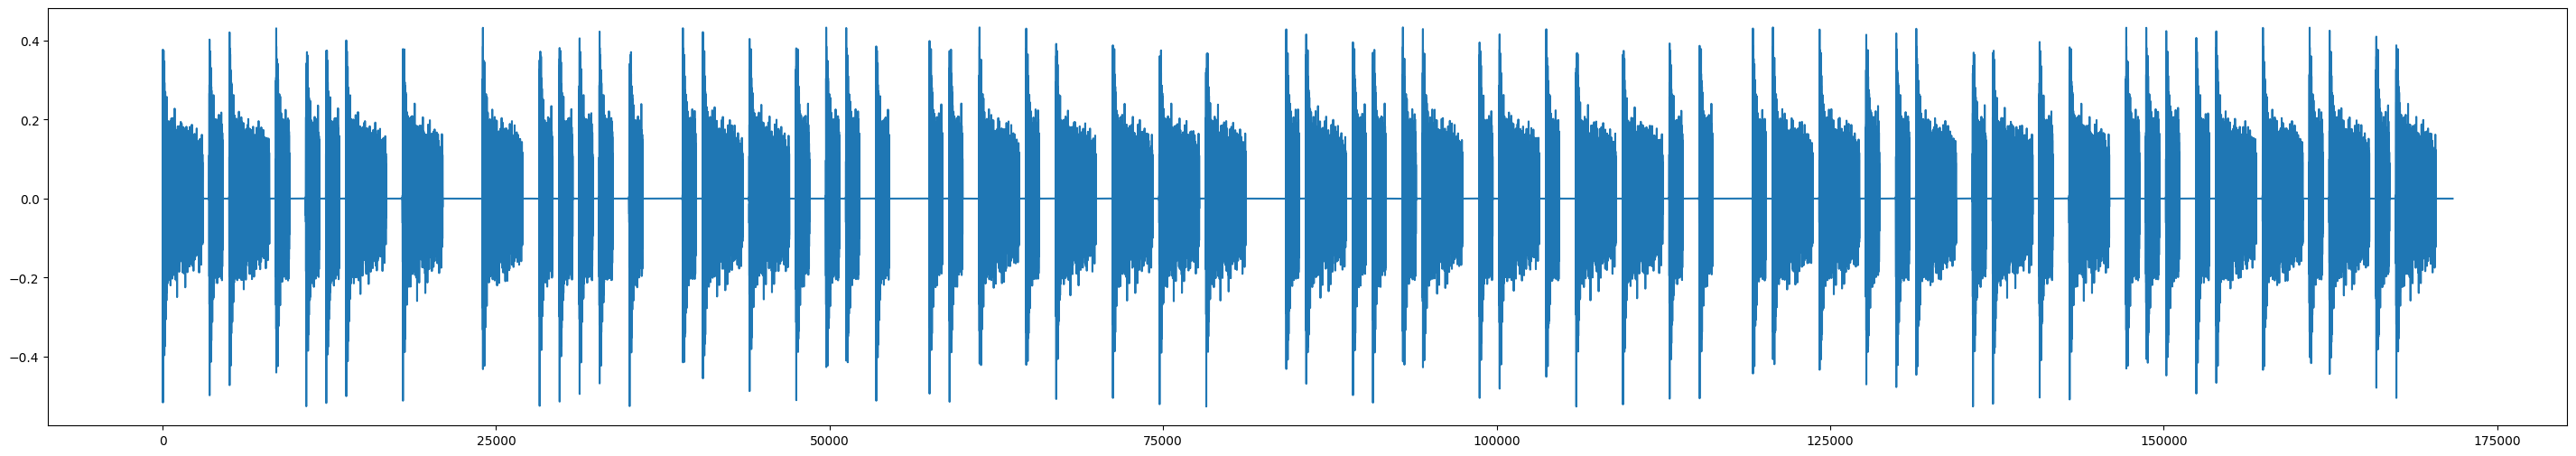

In [26]:
fig = plt.figure(figsize=(36, 6))
plt.plot(samples)
max_abs_scaler = preprocessing.MaxAbsScaler()
new_samples = max_abs_scaler.fit_transform(np.array(samples).reshape(1,-1).T)
# new_samples = ((pd.Series(samples) - min(samples)) * (1 - (-1))) / (max(samples) - min(samples)) + (-1)
threshold =np.mean(list(map(lambda i: abs(i), new_samples)))
bin_samples = [1 if abs(new_val)>threshold else 0 for new_val in new_samples]
new_samples = new_samples[bin_samples.index(1):max([i for i ,e in enumerate(bin_samples) if e == 1])+1]
bin_samples = bin_samples[bin_samples.index(1):max([i for i ,e in enumerate(bin_samples) if e == 1])+1]
border = 100
new_bin_samples =  [1 for i in range(border)] + \
[(1 if (bin_samples[i] ==1 or (np.sum(bin_samples[i-border:i]) > 0 and np.sum(bin_samples[i:i+border]) > 0)) else 0) \
    for i in list(range(border, len(bin_samples)-border))] + \
        [1 for i in range(border)]

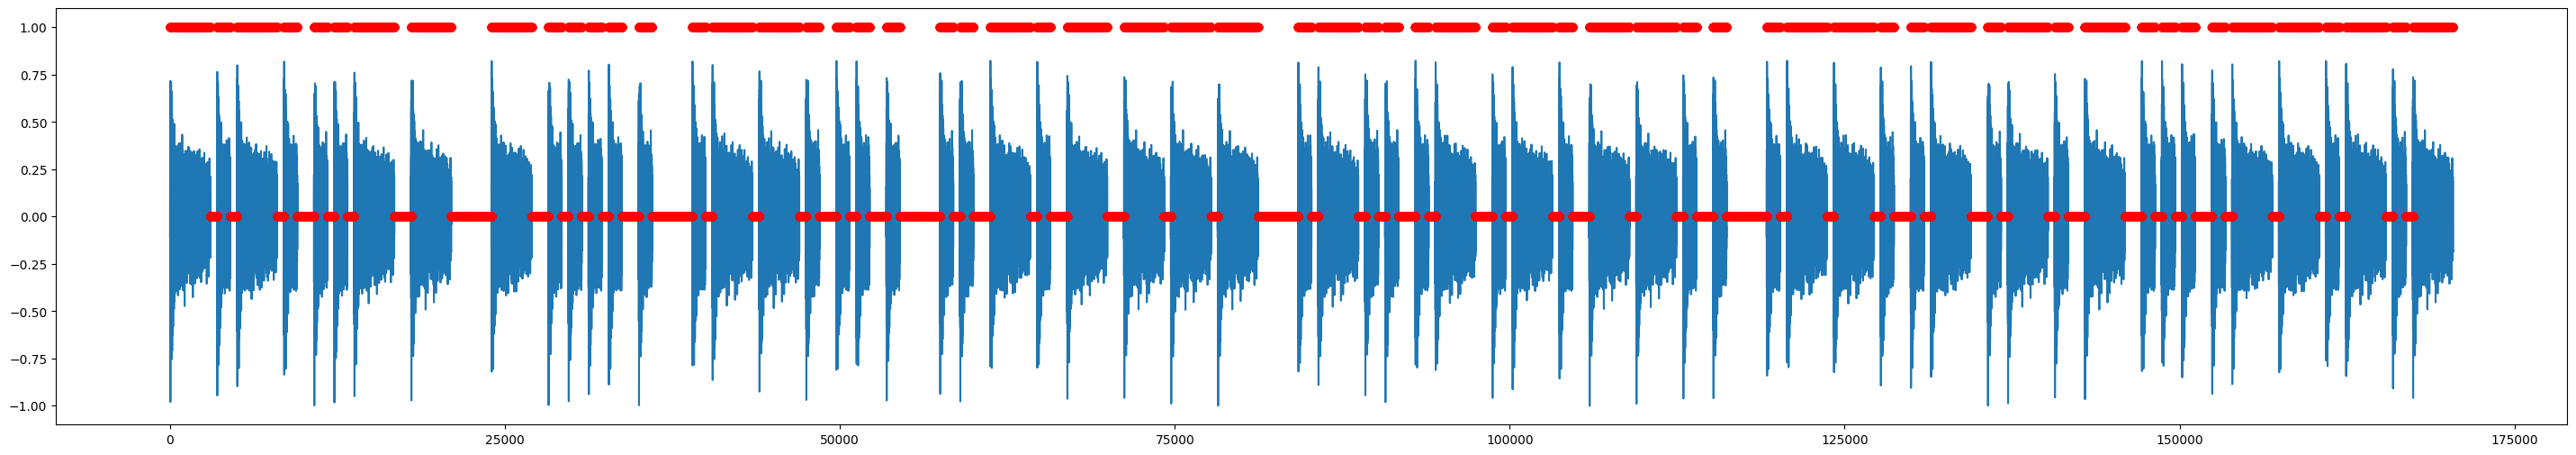

In [27]:
fig = plt.figure(figsize=(36, 6))
# plt.scatter([i for i, e in enumerate(new_bin_samples) if e == 1], [0 for i in new_bin_samples if i ==1],color = 'red', zorder =2)
plt.scatter([i for i, e in enumerate(new_bin_samples)],  new_bin_samples,color = 'red', zorder =2)

plt.plot(range(len(new_samples)), new_samples, zorder = 1)
plt.show()

In [28]:
new_list = []
k = 0
for i in range(len(new_bin_samples)-1):
    if new_bin_samples[i] != new_bin_samples[i+1]:
        if new_bin_samples[i] == 1:
            new_list.append(i-k+1)
        else:
            new_list.append(-(i+1-k))
        k = i 
new_list.append(len(new_bin_samples)-k)
# new_list = [i for i in new_list if abs(i)>max(new_list)/10]


(array([ 5.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0., 18.,  0.,  0.,  0.,  0.,  0., 38.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0., 36.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 26.]),
 array([-3.00000e+03, -2.88002e+03, -2.76004e+03, -2.64006e+03,
        -2.52008e+03, -2.40010e+03, -2.28012e+03, -2.16014e+03,
        -2.04016e+03, -1.92018e+03, -1.80020e+03, -1.68022e+03,
        -1.56024e+03, -1.44026e+03, -1.32028e+03, -1.20030e+03,
        -1.08032e+03, -9.60340e+02, -8.40360e+02, -7.20380e+02,
        -6.00400e+02, -4.80420e+02, -3.60440e+02, -2.40460e+02,
        -1.20480e+02, -5.00000e-01,  1.19480e+02,  2.39460e+02,
         3.59440e+02,  4.79420e+02,  5.99400e+02,  7.19380e+02,
         8.39360e+02,  9.59340e+02,  1.07932e+03,  1.19930e+03,
         1.31928e+03,  1.43926e+03,  1.55924e+03,  1.67922e+03,
         1.79920e+03,  1.91918e+03,  2.03916e+03,  2.15914e+03,
         2.2

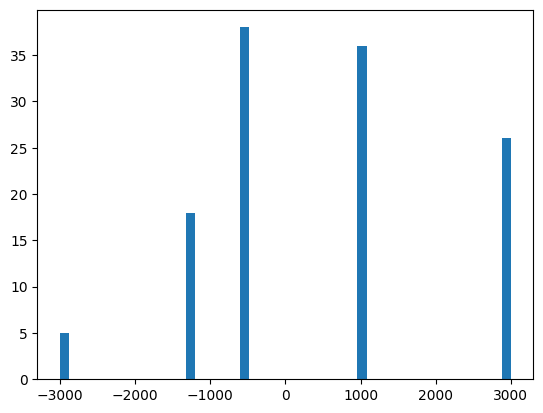

In [29]:
plt.hist([i for i in new_list if abs(i)>100], 50)

In [30]:
new_list = [i for i in new_list if abs(i)>100]

(array([ 5.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0., 18.,  0.,  0.,  0.,  0.,  0., 38.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0., 36.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 26.]),
 array([-3.00000e+03, -2.88002e+03, -2.76004e+03, -2.64006e+03,
        -2.52008e+03, -2.40010e+03, -2.28012e+03, -2.16014e+03,
        -2.04016e+03, -1.92018e+03, -1.80020e+03, -1.68022e+03,
        -1.56024e+03, -1.44026e+03, -1.32028e+03, -1.20030e+03,
        -1.08032e+03, -9.60340e+02, -8.40360e+02, -7.20380e+02,
        -6.00400e+02, -4.80420e+02, -3.60440e+02, -2.40460e+02,
        -1.20480e+02, -5.00000e-01,  1.19480e+02,  2.39460e+02,
         3.59440e+02,  4.79420e+02,  5.99400e+02,  7.19380e+02,
         8.39360e+02,  9.59340e+02,  1.07932e+03,  1.19930e+03,
         1.31928e+03,  1.43926e+03,  1.55924e+03,  1.67922e+03,
         1.79920e+03,  1.91918e+03,  2.03916e+03,  2.15914e+03,
         2.2

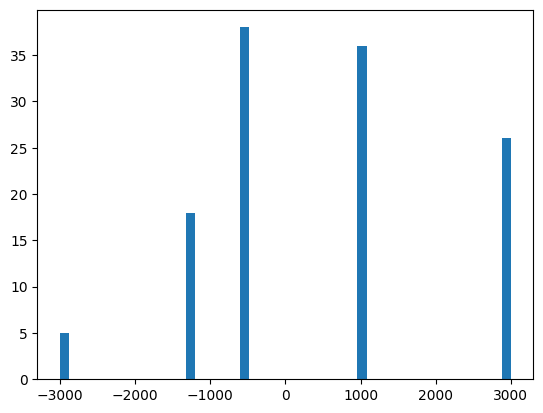

In [31]:
plt.hist([i for i in new_list], 50)

In [32]:


scaler = StandardScaler()
scaled = scaler.fit_transform(np.array([i for i in new_list]).reshape(1,-1).T)
silhouette_coefficients = []
for k in range(2, 6):
    if(len(scaled)>k):
        clustering = SpectralClustering(n_clusters=k).fit(scaled)
        score = silhouette_score(scaled, clustering.labels_)
        silhouette_coefficients.append(score)

n_clust = silhouette_coefficients.index(max(silhouette_coefficients))+2
clustering = SpectralClustering(n_clusters=n_clust)
clustering.fit(scaled)

df = pd.DataFrame(columns = ['length', 'class'])
df['length'] = new_list
df['class'] = clustering.labels_

cB0 =df['class']
ord_idx=np.argsort(df.groupby(['class']).mean()['length'])
cntrs = np.zeros_like(cB0)-1
for i in np.arange(n_clust):
    cntrs[cB0==ord_idx[i]]=i

In [33]:
cntrs

array([4, 2, 3, 2, 4, 2, 3, 1, 3, 2, 3, 2, 4, 1, 4, 0, 4, 1, 3, 2, 3, 2,
       3, 2, 3, 1, 3, 0, 3, 2, 4, 2, 4, 2, 3, 1, 3, 2, 3, 1, 3, 0, 3, 2,
       3, 1, 4, 2, 3, 1, 4, 1, 4, 2, 4, 2, 4, 0, 3, 2, 4, 2, 3, 2, 3, 1,
       3, 2, 4, 1, 3, 2, 4, 2, 3, 1, 4, 2, 4, 2, 3, 1, 3, 0, 3, 2, 4, 2,
       4, 2, 3, 1, 3, 2, 4, 1, 3, 2, 4, 2, 3, 1, 4, 1, 3, 2, 3, 2, 3, 1,
       3, 2, 4, 2, 4, 2, 3, 2, 4, 2, 3, 2, 4], dtype=int32)

In [34]:


df = pd.DataFrame(columns = ['length', 'class'])
df['length'] = new_list
df['class'] = cntrs
dict = dict_class_to_morse(np.array([np.sort(df.groupby(['class']).mean()['length'])]).T)


In [35]:
"".join([dict.get(i) for i in df['class']])

'-,.,-,._.,.,-_- -_.,.,.,._. .,-,-,._.,._. .,._-,._-_-,-,- .,-,.,._.,-_.,-,._-,-,._. .,-,-,._.,-_.,-,._-_.,.,._.,-,-,.,-,.,-'

In [312]:
translator_from_morse('-_._.,-,._.,-_-,-,.,.')

'TERAZ'

In [313]:
translator_from_morse('.,.,._.,._.,.,-,.,.')

TypeError: sequence item 2: expected str instance, NoneType found

In [310]:
translator_from_morse("".join([dict.get(i) for i in df['class']])) 

TypeError: sequence item 2: expected str instance, NoneType found

In [325]:
samples, sampling_rate = librosa.load("/Users/zuzannaglinka/Library/Developer/CoreSimulator/Devices/5B03F63E-5182-47D3-BA2A-584FA601AAEF/data/Containers/Data/Application/01F8859C-9797-4759-A474-059656BBA2EE/Documents/recordings/recording-1702411880908.wav", sr=10000, mono=True, offset=0.0
                    , duration=None)

In [328]:
samples, sampling_rate = librosa.load("/Users/zuzannaglinka/Library/Developer/CoreSimulator/Devices/5B03F63E-5182-47D3-BA2A-584FA601AAEF/data/Containers/Data/Application/01F8859C-9797-4759-A474-059656BBA2EE/Documents/recordings/recording-1702414911886.wav", sr=10000, mono=True, offset=0.0
                    , duration=None)

In [173]:
samples, sampling_rate = librosa.load("/Users/zuzannaglinka/Downloads/morse1dow.wav")

In [329]:
max_abs_scaler = preprocessing.MaxAbsScaler()
new_samples = max_abs_scaler.fit_transform(np.array(samples).reshape(1,-1).T)

In [270]:
len(new_samples)

82130

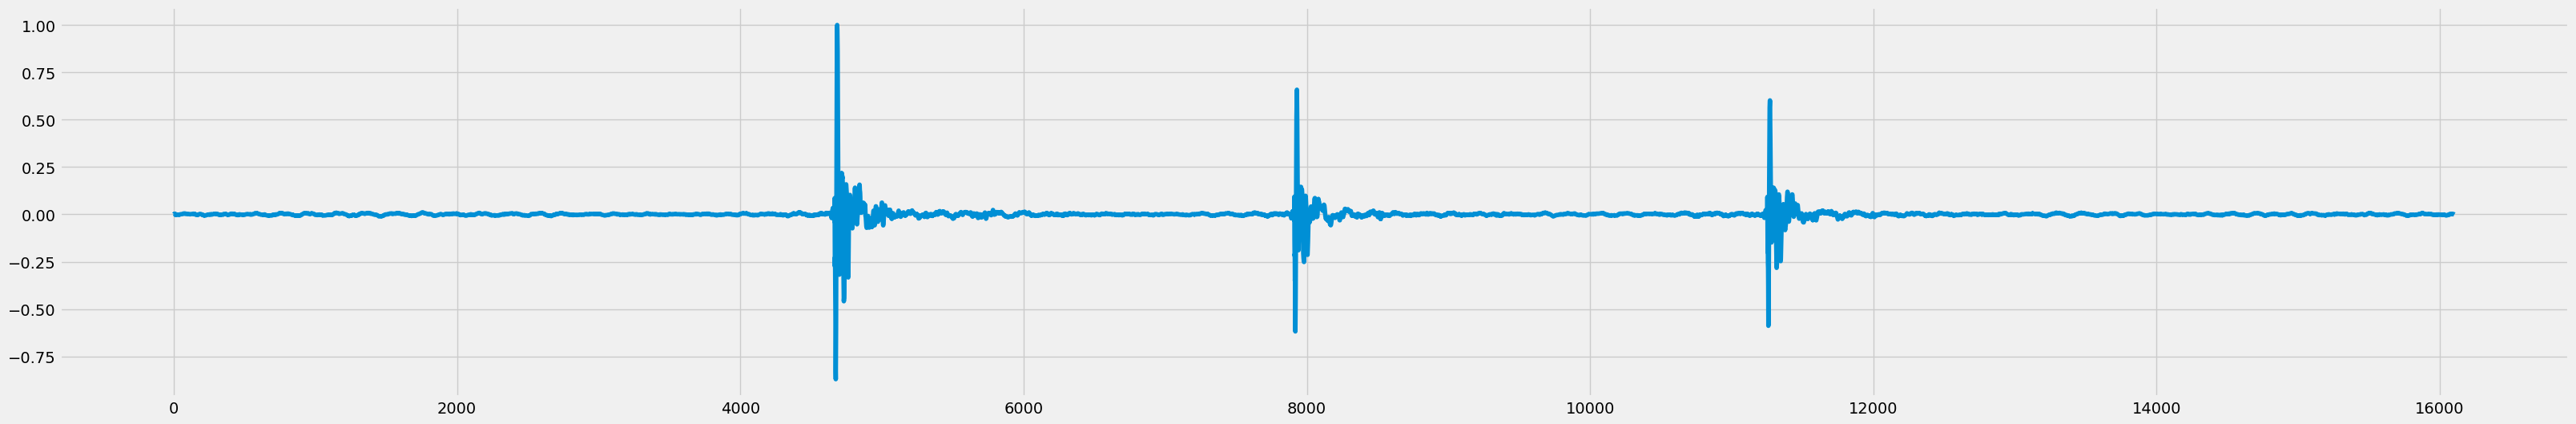

In [330]:
fig = plt.figure(figsize=(36, 6))
plt.plot(new_samples)
# plt.scatter( [i for i, e in enumerate(labels) if e == 1], [0 for i in labels if i ==1], c = 'red', zorder = 2)


In [318]:
len(new_samples)

16104

In [319]:
len(new_samples[new_samples<0.05])/len(new_samples)

0.986214605067064

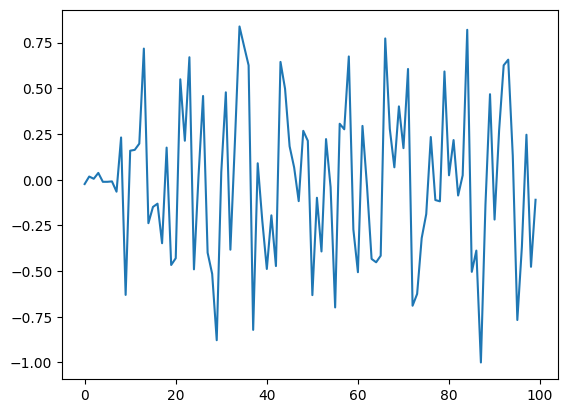

In [121]:
plt.plot((new_samples[:100]))

In [91]:
new_samples = new_samples.T[0]

In [141]:
new_list_no_outliers = [i if np.quantile(new_samples, 0.95) > i > np.quantile(new_samples, 0.05) else (np.quantile(new_samples, 0.95) if np.quantile(new_samples, 0.95) < i else np.quantile(new_samples, 0.05)) for i in new_samples] 

KeyboardInterrupt: 

In [93]:
new_samples = new_list_no_outliers

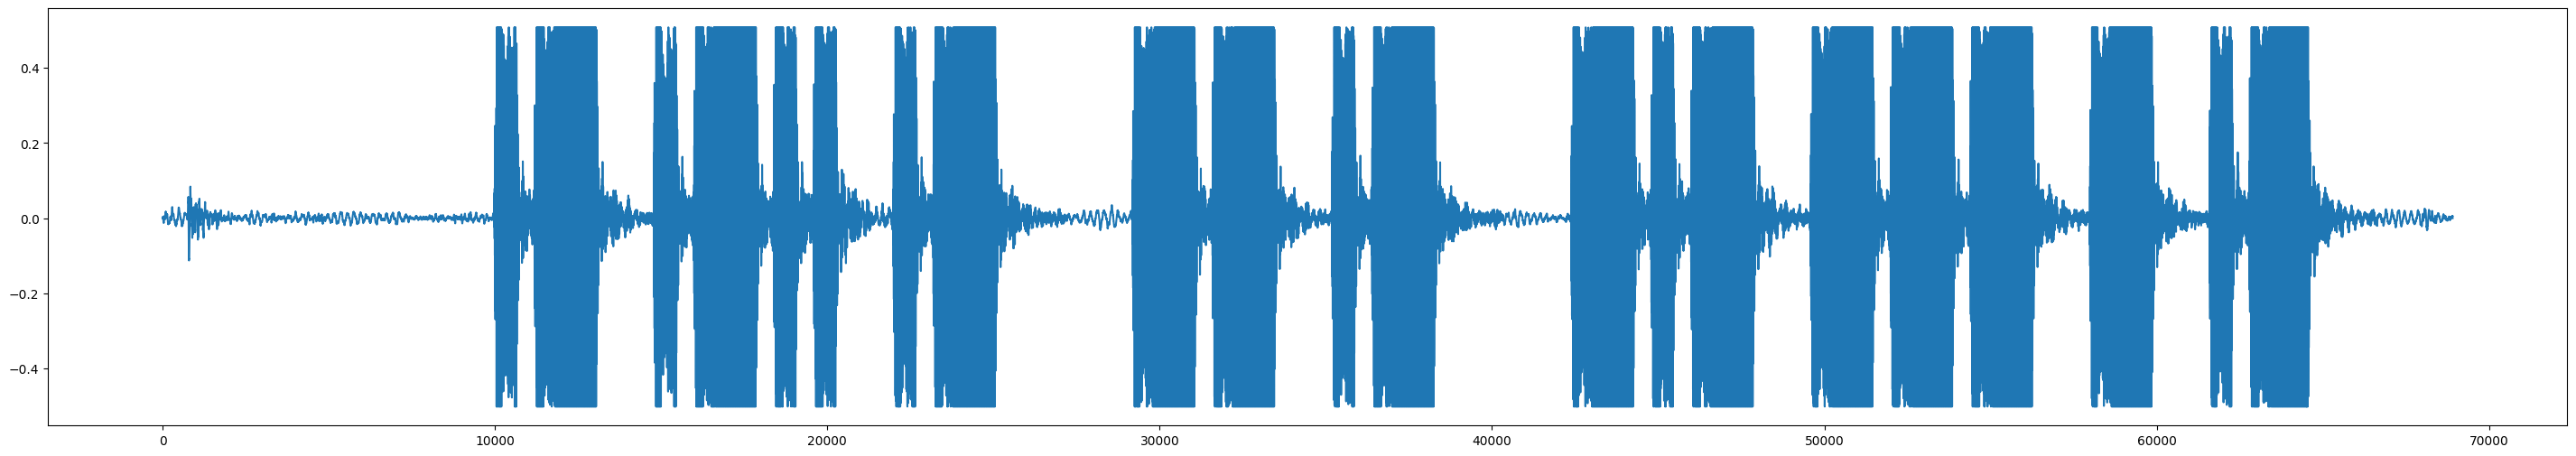

In [142]:
fig = plt.figure(figsize=(36, 6))
plt.plot(new_list_no_outliers)

In [320]:
threshold = np.mean(list(map(lambda i: abs(i), new_samples)))
threshold

0.008890034

In [159]:
len(list(filter(lambda new_list_no_outliers: new_list_no_outliers <threshold, new_list_no_outliers)))/len(new_list_no_outliers)

0.8250464414257518

In [321]:
max_abs_scaler = preprocessing.MaxAbsScaler()
new_samples = max_abs_scaler.fit_transform(np.array(new_list_no_outliers).reshape(1,-1).T)

In [15]:
!pip install noisereduce

In [70]:
import noisereduce as nr

In [73]:
# reduced_noise = nr.reduce_noise(y=samples, sr=sampling_rate)


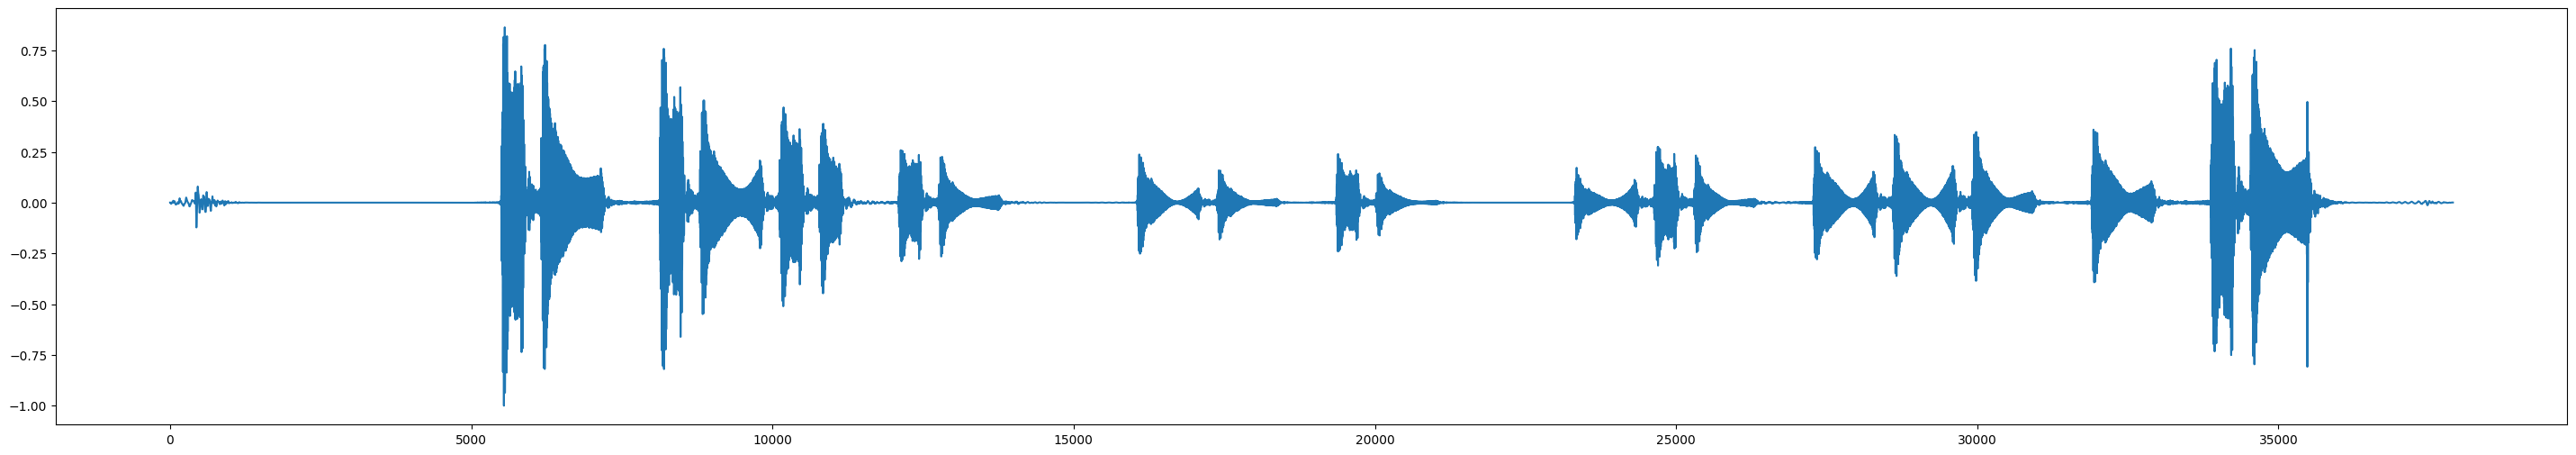

In [74]:
# max_abs_scaler = preprocessing.MaxAbsScaler()
# new_samples = max_abs_scaler.fit_transform(np.array(reduced_noise).reshape(1,-1).T)
# fig = plt.figure(figsize=(36, 6))
# plt.plot(new_samples)

In [331]:
threshold =np.mean(list(map(lambda i: abs(i), new_samples)))
bin_samples = [1 if abs(new_val)>threshold else 0 for new_val in new_samples]
# usuwanie ciszy na koncu i na poczatku pliku 
new_samples = new_samples[bin_samples.index(1):max([i for i ,e in enumerate(bin_samples) if e == 1])+1]
bin_samples = bin_samples[bin_samples.index(1):max([i for i ,e in enumerate(bin_samples) if e == 1])+1]


In [332]:
border = 100
new_bin_samples =  [1 for i in range(border)]+ [(1 if (bin_samples[i] ==1 or (bin_samples[i] == 0 and np.sum(bin_samples[i-border:i]) != 0 and np.sum(bin_samples[i+1:i+border]) != 0)) else 0) for i in list(range(border, len(bin_samples)-border))] + [1 for i in range(border)]


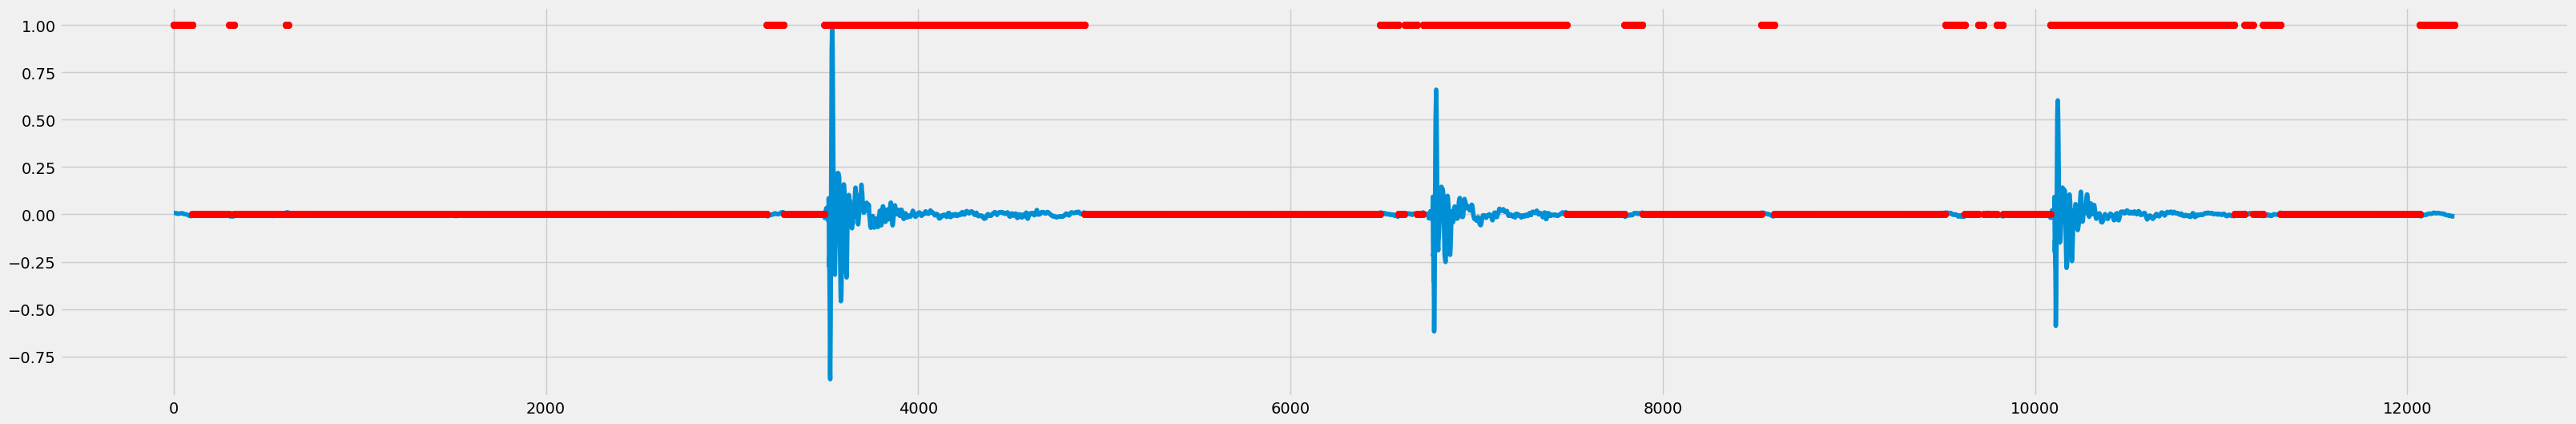

In [333]:
fig = plt.figure(figsize=(36, 6))
# plt.scatter([i for i, e in enumerate(new_bin_samples) if e == 1], [0 for i in new_bin_samples if i ==1],color = 'red', zorder =2)
plt.scatter([i for i, e in enumerate(new_bin_samples)],  new_bin_samples,color = 'red', zorder =2)

plt.plot(range(len(new_samples)), new_samples, zorder = 1)
plt.show()

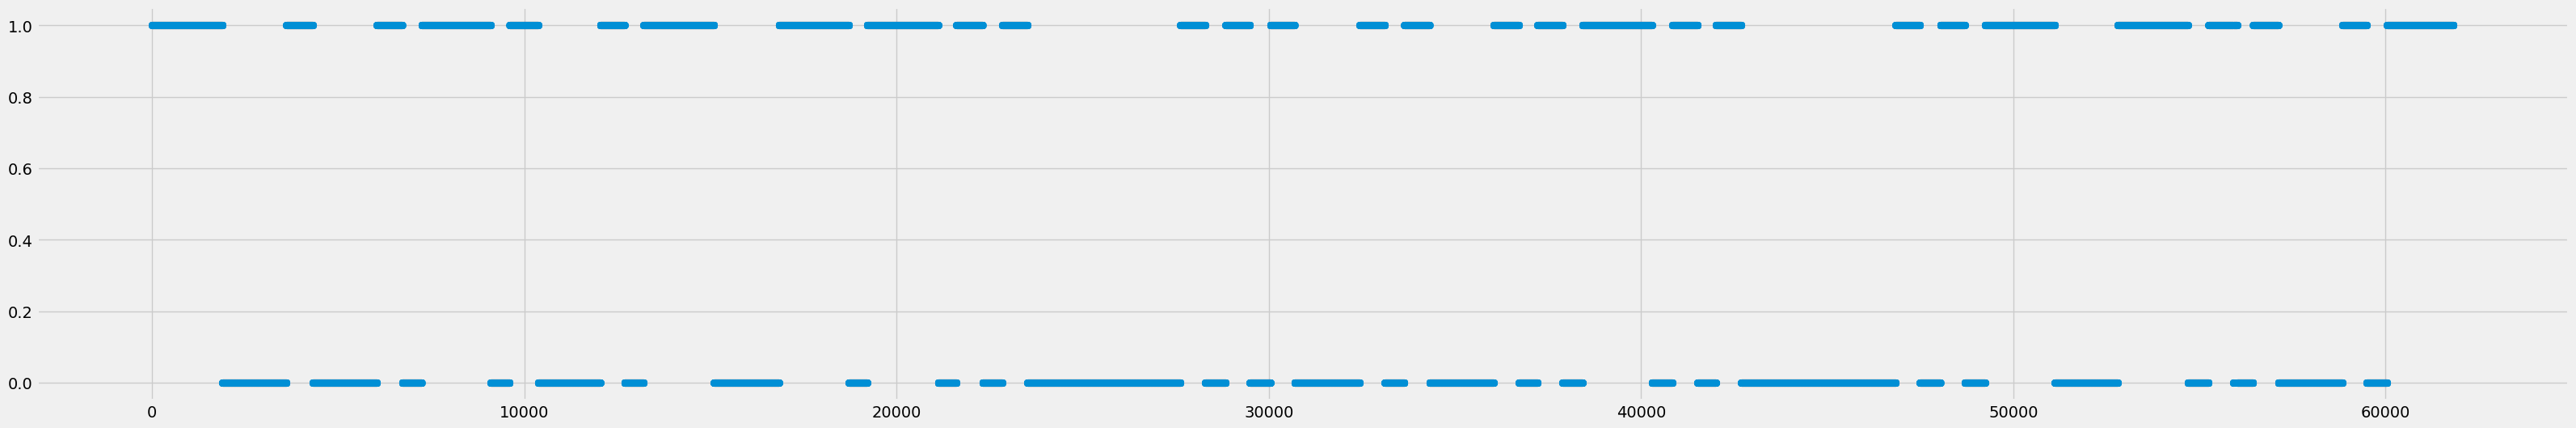

In [276]:
fig = plt.figure(figsize=(36, 6))
plt.scatter(range(len(new_bin_samples)), new_bin_samples)

In [277]:
new_list = []
k = 0
for i in range(len(new_bin_samples)-1):
    if new_bin_samples[i] != new_bin_samples[i+1]:
        if new_bin_samples[i] == 1:
            new_list.append(i-k+1)
        else:
            new_list.append(-(i+1-k))
        k = i 
new_list.append(len(new_bin_samples)-k)

(array([ 2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  2.,  6.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0., 12.,  6.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        17.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  8.]),
 array([-4150. , -4028.8, -3907.6, -3786.4, -3665.2, -3544. , -3422.8,
        -3301.6, -3180.4, -3059.2, -2938. , -2816.8, -2695.6, -2574.4,
        -2453.2, -2332. , -2210.8, -2089.6, -1968.4, -1847.2, -1726. ,
        -1604.8, -1483.6, -1362.4, -1241.2, -1120. ,  -998.8,  -877.6,
         -756.4,  -635.2,  -514. ,  -392.8,  -271.6,  -150.4,   -29.2,
           92. ,   213.2,   334.4,   455.6,   576.8,   698. ,   819.2,
          940.4,  1061.6,  1182.8,  1304. ,  1425.2,  1546.4,  1667.6,
         1788.8,  1910. ]),
 <BarContainer object of 50 artists>)

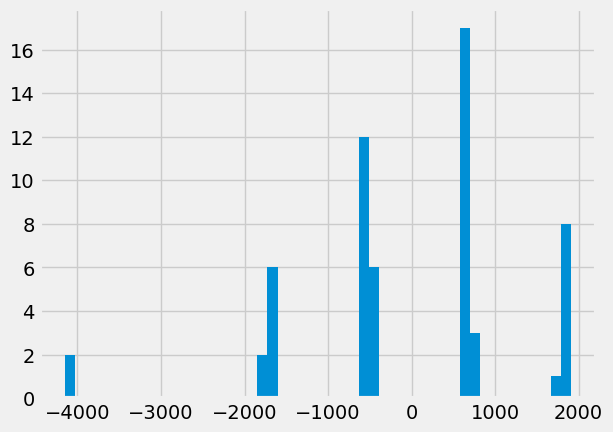

In [278]:
plt.hist([i for i in new_list if abs(i)>100], 50)

In [279]:
new_list = [i for i in new_list if abs(i)>50]

In [280]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


In [281]:
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering


In [282]:
scaler = StandardScaler()
scaled = scaler.fit_transform(np.array([i for i in new_list]).reshape(1,-1).T)
silhouette_coefficients = []
for k in range(2, 6):
    if(len(scaled)>k):
        print(k)
        # kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
        clustering = SpectralClustering(n_clusters=k).fit(scaled)
        # estimator = make_pipeline(StandardScaler(), kmeans).fit(np.array(new_list).reshape(1,-1).T)
        # kmeans.fit(scaled)
        print(clustering.labels_)

        score = silhouette_score(scaled, clustering.labels_)
        print(score)
        silhouette_coefficients.append(score)



2
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
0.6851558492904813
3
[2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 1 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2
 0 2 0 2 1 2 0 2 0 2 0 2 0 2 2 0 2 0 2 0 2]
0.7102224765257708
4
[2 3 0 3 0 0 2 0 0 3 0 0 2 3 2 0 2 0 0 0 0 1 0 0 0 0 0 3 0 0 0 3 0 0 0 0 2
 0 0 0 0 1 0 0 0 0 2 3 2 0 0 0 0 0 3 0 0 2]
0.6435377973419175
5
[3 0 2 0 2 4 3 4 2 0 2 4 3 0 3 4 3 4 2 4 2 1 2 4 2 4 2 0 2 4 2 0 2 4 2 4 3
 4 2 4 2 1 2 4 2 4 3 0 3 4 2 2 4 2 0 2 4 3]
0.9486452992443369


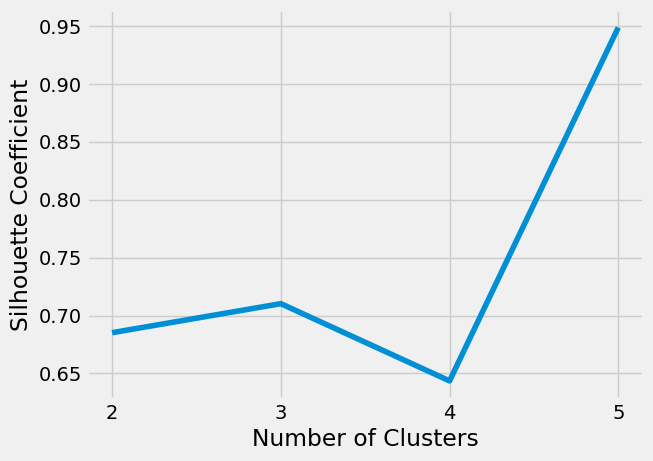

In [283]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 6), silhouette_coefficients)
plt.xticks(range(2, 6))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [284]:
n_clust = silhouette_coefficients.index(max(silhouette_coefficients))+2
clustering = SpectralClustering(n_clusters=n_clust)
clustering.fit(scaled)

SpectralClustering(n_clusters=5)

In [285]:
# Final locations of the centroid
df = pd.DataFrame(columns = ['length', 'class'])
df['length'] = new_list
df['class'] = clustering.labels_
df.head(15)


,length,class
0,1891,0
1,-1719,3
2,710,2
3,-1722,3
4,681,2
5,-523,4
6,1857,0
7,-509,4
8,769,2
9,-1668,3


In [193]:
cB0 =df['class']
ord_idx=np.argsort(df.abs().groupby(['class']).mean()['length'])
cntrs = np.zeros_like(cB0)-1
for i in np.arange(n_clust):
    cntrs[cB0==ord_idx[i]]=i

print(cntrs)

[1 0 3 2 1 0 0 3 0 1 0 1 2 1 0 0 3 4 3 0 3 2 1 0 0 3 4 3 0 1 0 3 2 3 0 3 0
 3 2 3 2 1 0 0 3]


In [194]:
df = pd.DataFrame(columns = ['length', 'class'])
df['length'] = new_list
df['class'] = cntrs
# df['class'] += len(df.loc[df['length']<0, 'class'].unique())
# print(df['class'].unique())
# if(len(df['class'].unique()) == 3):
#     df.loc[df['class']==4,'class'] = 0
# df = df.apply(lambda row:[row['length'], row['class']-len(df.loc[df['length']<0, 'class'].unique())+(1 if len(df['class'].unique()) == 3 else 0)]  if row['length'] < 0 and row['class']!= 0 else [row['length'], row['class']], axis=1, result_type = 'broadcast')
# else:
#         df = df.apply(lambda row:[row['length'], row['class']-len(df.loc[df['length']<0, 'class'].unique())]  if row['length'] < 0 and row['class']!= 0 else [row['length'], row['class']], axis=1, result_type = 'broadcast')


In [195]:
df = pd.DataFrame(columns = ['length', 'class'])
df['length'] = new_list
df['class'] = cntrs
class_to_sign = dict_class_to_morse(np.array([np.sort(df.groupby(['class']).mean()['length'])]).T)

In [196]:
class_to_sign

{0: ' ', 1: '_', 2: ',', 3: '.', 4: '-'}

In [197]:
[class_to_sign.get(i) for i in df['class']]

['_',
 ' ',
 '.',
 ',',
 '_',
 ' ',
 ' ',
 '.',
 ' ',
 '_',
 ' ',
 '_',
 ',',
 '_',
 ' ',
 ' ',
 '.',
 '-',
 '.',
 ' ',
 '.',
 ',',
 '_',
 ' ',
 ' ',
 '.',
 '-',
 '.',
 ' ',
 '_',
 ' ',
 '.',
 ',',
 '.',
 ' ',
 '.',
 ' ',
 '.',
 ',',
 '.',
 ',',
 '_',
 ' ',
 ' ',
 '.']

In [198]:
text = "".join([class_to_sign.get(i) for i in df['class']])
text

'_ .,_  . _ _,_  .-. .,_  .-. _ .,. . .,.,_  .'

In [1133]:
translator_from_morse("".join([class_to_sign.get(i) for i in df['class']]))

'1'